In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/DATASET-SafaCycle'

In [4]:
# Paths
train_dir = '/content/drive/MyDrive/DATASET-SafaCycle/TRAIN'
test_dir = '/content/drive/MyDrive/DATASET-SafaCycle/TEST'

# Image dimensions
IMG_SIZE = 224  # Better than 128 for transfer learning
BATCH_SIZE = 32
EPOCHS = 15


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 19432 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [6]:
# Load base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("waste_classifier_best.h5", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

In [10]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 1/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9399 - loss: 0.1518

608/608 ━━━━━━━━━━━━━━━━━━━━ 1887s 3s/step - accuracy: 0.9399 - loss: 0.1518 - val_accuracy: 0.8452 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 2/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 1354s 2s/step - accuracy: 0.9488 - loss: 0.1344 - val_accuracy: 0.8392 - val_loss: 0.3965 - learning_rate: 0.0010
Epoch 3/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9535 - loss: 0.1224

608/608 ━━━━━━━━━━━━━━━━━━━━ 1303s 2s/step - accuracy: 0.9535 - loss: 0.1224 - val_accuracy: 0.8591 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 4/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - accuracy: 0.9557 - loss: 0.1126 - val_accuracy: 0.8309 - val_loss: 0.3802 - learning_rate: 0.0010
Epoch 5/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9601 - loss: 0.1006
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
608/608 ━━━━━━━━━━━━━━━━━━━━ 1304s 2s/step - accuracy: 0.9601 - loss: 0.1006 - val_accuracy: 0.7879 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 6/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.9662 - loss: 0.0868 - val_accuracy: 0.8424 - val_loss: 0.3848 - learning_rate: 2.0000e-04
Epoch 7/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9697 - loss: 0.0823
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
608/608 ━━━━━━━━━━━━━━━━━━━━ 1339s 2s/step - accuracy: 0.9697 - loss: 0.0823 -

In [12]:
# Accuracy
loss, accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9394 - loss: 0.1394
Validation Accuracy: 85.91%


In [13]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=['Biodegradable', 'Non-Biodegradable']))

79/79 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step
Confusion Matrix:
 [[1374   27]
 [ 327  785]]

Classification Report:
                    precision    recall  f1-score   support

    Biodegradable       0.81      0.98      0.89      1401
Non-Biodegradable       0.97      0.71      0.82      1112

         accuracy                           0.86      2513
        macro avg       0.89      0.84      0.85      2513
     weighted avg       0.88      0.86      0.85      2513



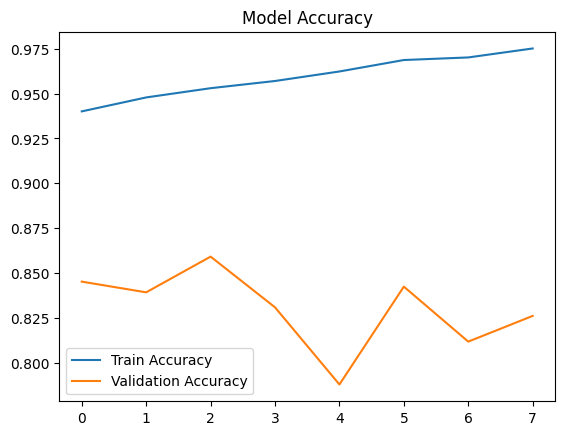

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [17]:
# Save in new format
model.save('waste_classifier_final.keras')

# Later load it
from tensorflow import keras
model = keras.models.load_model('waste_classifier_final.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
